<a href="https://colab.research.google.com/github/NabilBADRI/Pre-trained-Language-Models-for-Abusive-and-Hate-speech-Classification-in-Arab/blob/main/Bert_base_arabic_with_Egyptian_train_and_test_of_all_dialect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd 

from sklearn.model_selection import train_test_split,RepeatedStratifiedKFold, KFold, cross_val_score

from pathlib import Path
import numpy as np 
import torch
from torch.utils.data import Dataset, DataLoader
!pip install transformers
!pip install nlpaug 
import transformers
from transformers import AutoModel, BertTokenizerFast, AutoModelForSequenceClassification, Trainer, TrainingArguments

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.7 MB/s 
     |████████████████████████████████| 120 kB 72.4 MB/s 
     |████████████████████████████████| 6.6 MB 53.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 410 kB 4.9 MB/s 


In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

In [ ]:
from google.colab import files 
import io 
uploaded =files.upload()

Saving D5.xlsx to D5.xlsx


In [ ]:
df = pd.read_excel(io.BytesIO(uploaded['D5.xlsx']))
df.head()

,commentaire,classe
0,مبروك و سامحونا لعجزنا التام. عقبال اللي جوه. ...,normal
1,كلنا بره ومش هنبطل نزايد على العجايز الي جابون...,hate
2,بدل ما انت قاعد بره كده تعالي ازرع الصحرا,normal
3,قذر اتفووو ماتيجى مصر وتورينا نفسك كدا ياجبان,hate
4,وهكذا رجال الشو اللي محرومين من عمل برنامج الغ...,hate


In [ ]:
df['classe'].value_counts()

normal     453
hate       444
abusive    203
Name: classe, dtype: int64

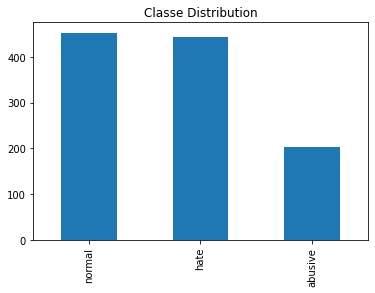

In [ ]:
df.classe.value_counts().plot.bar(x=df.classe.unique(), title='Classe Distribution')

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df['Label']=le.fit_transform(df['classe'])
df.head(6)

,commentaire,classe,Label
0,مبروك و سامحونا لعجزنا التام. عقبال اللي جوه. ...,normal,2
1,كلنا بره ومش هنبطل نزايد على العجايز الي جابون...,hate,1
2,بدل ما انت قاعد بره كده تعالي ازرع الصحرا,normal,2
3,قذر اتفووو ماتيجى مصر وتورينا نفسك كدا ياجبان,hate,1
4,وهكذا رجال الشو اللي محرومين من عمل برنامج الغ...,hate,1
5,أنت أزاي لبؤة كدة ؟,abusive,0


In [ ]:
import re
!pip install pyarabic
import pyarabic.araby as araby

prefix_list = [
    "ال",
    "و",
    "ف",
    "ب",
    "ك",
    "ل",
    "لل",
    "\u0627\u0644",
    "\u0648",
    "\u0641",
    "\u0628",
    "\u0643",
    "\u0644",
    "\u0644\u0644",
    "س",
]
suffix_list = [
    "ه",
    "ها",
    "ك",
    "ي",
    "هما",
    "كما",
    "نا",
    "كم",
    "هم",
    "هن",
    "كن",
    "ا",
    "ان",
    "ين",
    "ون",
    "وا",
    "ات",
    "ت",
    "ن",
    "ة",
    "\u0647",
    "\u0647\u0627",
    "\u0643",
    "\u064a",
    "\u0647\u0645\u0627",
    "\u0643\u0645\u0627",
    "\u0646\u0627",
    "\u0643\u0645",
    "\u0647\u0645",
    "\u0647\u0646",
    "\u0643\u0646",
    "\u0627",
    "\u0627\u0646",
    "\u064a\u0646",
    "\u0648\u0646",
    "\u0648\u0627",
    "\u0627\u062a",
    "\u062a",
    "\u0646",
    "\u0629",
]
other_tokens = ["[رابط]", "[مستخدم]", "[بريد]"]

# the never_split list is ussed with the transformers library
prefix_symbols = [x + "+" for x in prefix_list]
suffix_symblos = ["+" + x for x in suffix_list]
never_split_tokens = list(set(prefix_symbols + suffix_symblos + other_tokens))

regex_url_step1 = r"(?=http)[^\s]+"
regex_url_step2 = r"(?=www)[^\s]+"
regex_url = r"(http(s)?:\/\/.)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)"
regex_mention = r"@[\w\d]+"
regex_email = r"\S+@\S+"
redundant_punct_pattern = (
    r"([!\"#\$%\'\(\)\*\+,\.:;\-<=·>?@\[\\\]\^_ـ`{\|}~—٪’،؟`୍“؛”ۚ【»؛\s+«–…‘]{2,})"
)


def remove_elongation(word):
    """
	:param word:  the input word to remove elongation
	:return: delongated word
	"""
    regex_tatweel = r"(\w)\1{2,}"
    # loop over the number of times the regex matched the word
    for index_ in range(len(re.findall(regex_tatweel, word))):
        if re.search(regex_tatweel, word):
            elongation_found = re.search(regex_tatweel, word)
            elongation_replacement = elongation_found.group()[0]
            elongation_pattern = elongation_found.group()
            word = re.sub(
                elongation_pattern, elongation_replacement, word, flags=re.MULTILINE
            )
        else:
            break
    return word


def tokenize_arabic_words_farasa(line_input, farasa_segmenter, use_farasapy):
    if use_farasapy:
        if type(farasa_segmenter).__name__ == "FarasaSegmenter":
            line_farasa = farasa_segmenter.segment(line_input).split()
        else:
            raise TypeError(
                'use_farsapy is set to True. farasa must be a "py4j.java_gateway.JavaObject"'
            )
    else:
        if type(farasa_segmenter).__name__ == "JavaObject":
            line_farasa = farasa_segmenter.segmentLine(line_input)
        else:
            raise TypeError(
                'use_farsapy is set to False. farasa must be a "FarasaSegmenter" instance from farasapy.segmenter'
            )
    segmented_line = []
    for index, word in enumerate(line_farasa):
        if word in ["[", "]"]:
            continue
        if word in ["رابط", "بريد", "مستخدم"] and line_farasa[index - 1] in ["[", "]"]:
            segmented_line.append("[" + word + "]")
            continue
        segmented_word = []
        for token in word.split("+"):
            if token in prefix_list:
                segmented_word.append(token + "+")
            elif token in suffix_list:
                segmented_word.append("+" + token)
            else:
                segmented_word.append(token)
        segmented_line.extend(segmented_word)
    return " ".join(segmented_line)


def remove_redundant_punct(text):
    text_ = text
    result = re.search(redundant_punct_pattern, text)
    dif = 0
    while result:
        sub = result.group()
        sub = sorted(set(sub), key=sub.index)
        sub = " " + "".join(list(sub)) + " "
        text = "".join(
            (text[: result.span()[0] + dif], sub, text[result.span()[1] + dif :])
        )
        text_ = "".join((text_[: result.span()[0]], text_[result.span()[1] :])).strip()
        dif = abs(len(text) - len(text_))
        result = re.search(redundant_punct_pattern, text_)
    text = re.sub(r"\s+", " ", text)
    return text.strip()


def preprocess(text, do_farasa_tokenization=True, farasa=None, use_farasapy=False):
    """
	Preprocess takes an input text line an applies the same preprocessing used in araBERT 
				pretraining
	
	Note: a farasapy segmenter is ~6x faster than the py4j.java_gateway, consider setting use_farasapy=True
	Farsa Segmentation will soon be fully migrated to farasapy, and support for the py4j.java_gateway.JavaObject will be removed
	Args:
		text (string): inout text string
		farasa (JavaGateway): pass a "py4j.java_gateway.JavaObject" to the FarasaSegmenter.jar file 
		farasa (FarasaSegmenter): pass a FarasaSegmenter instance from farasapy.segmenter
		use_farasapy (boolean): set it to True when using a FarasaSegmenter instance from farasapy.segmenter
	Example: 
		from py4j.java_gateway import JavaGateway
		gateway = JavaGateway.launch_gateway(classpath='./FarasaSegmenterJar.jar')
		farasa = gateway.jvm.com.qcri.farasa.segmenter.Farasa()
		processed_text = preprocess("Some_Text",do_farasa_tokenization=True , farasa=farasa)
	"""
    text = str(text)
    processing_tweet = araby.strip_tashkeel(text)
    processing_tweet = re.sub(r"\d+\/[ء-ي]+\/\d+\]", "", processing_tweet)
    processing_tweet = re.sub("ـ", "", processing_tweet)
    processing_tweet = re.sub("[«»]", ' " ', processing_tweet)
    # replace the [رابط] token with space if you want to clean links
    processing_tweet = re.sub(regex_url_step1, "[رابط]", processing_tweet)
    processing_tweet = re.sub(regex_url_step2, "[رابط]", processing_tweet)
    processing_tweet = re.sub(regex_url, "[رابط]", processing_tweet)
    processing_tweet = re.sub(regex_email, "[بريد]", processing_tweet)
    processing_tweet = re.sub(regex_mention, "[مستخدم]", processing_tweet)
    processing_tweet = re.sub("…", r"\.", processing_tweet).strip()
    processing_tweet = remove_redundant_punct(processing_tweet)

    processing_tweet = re.sub(
        r"\[ رابط \]|\[ رابط\]|\[رابط \]", " [رابط] ", processing_tweet
    )
    processing_tweet = re.sub(
        r"\[ بريد \]|\[ بريد\]|\[بريد \]", " [بريد] ", processing_tweet
    )
    processing_tweet = re.sub(
        r"\[ مستخدم \]|\[ مستخدم\]|\[مستخدم \]", " [مستخدم] ", processing_tweet
    )

    processing_tweet = remove_elongation(processing_tweet)
    if do_farasa_tokenization and farasa is not None:
        processing_tweet = tokenize_arabic_words_farasa(
            processing_tweet, farasa, use_farasapy
        )
    return processing_tweet.strip()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 126 kB 4.9 MB/s 


In [ ]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['commentaire'], df['Label'], random_state=42, 
                                                                    test_size=0.3)

train_texts=train_texts.apply(preprocess)
temp_texts=temp_texts.apply(preprocess)

val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, random_state=42, 
                                                                test_size=0.5)

len(train_texts), len(val_texts), len(test_texts)

(770, 165, 165)

## **Bert-base-arabic**

In [ ]:
BERT_MODEL_NAME = 'asafaya/bert-base-arabic'

bert = AutoModel.from_pretrained(BERT_MODEL_NAME)

tokenizer_base_arabic = BertTokenizerFast.from_pretrained(BERT_MODEL_NAME)

Some weights of the model checkpoint at asafaya/bert-base-arabic were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


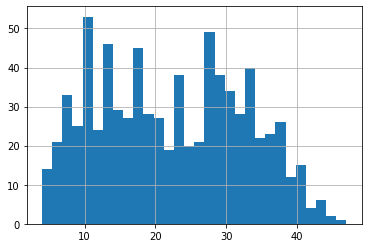

In [ ]:
seq_len = [len(tokenizer_base_arabic.encode(i)) for i in train_texts]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len = 502
model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL_NAME, num_labels=3)

Some weights of the model checkpoint at asafaya/bert-base-arabic were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at asafaya/bert-base-ar

In [ ]:
train_encodings = tokenizer_base_arabic(train_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)
val_encodings = tokenizer_base_arabic(val_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)
test_encodings = tokenizer_base_arabic(test_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)

In [ ]:
class preparerDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.to_list()

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = preparerDataset(train_encodings, train_labels)
val_dataset = preparerDataset(val_encodings, val_labels)
test_dataset = preparerDataset(test_encodings, test_labels)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# function to pass to out trainer in order to compute accuracy, f1 score, precision and recall
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_strategy='epoch',
    evaluation_strategy='epoch'
    )

base_arabic = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    compute_metrics=compute_metrics 
)

base_arabic.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 770
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 245


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.063600,1.026851,0.448485,0.333028,0.303140,0.373162
2,0.997600,0.963279,0.490909,0.408839,0.627856,0.424595
3,0.892800,0.811796,0.636364,0.588621,0.644444,0.582321
4,0.705500,0.796516,0.606061,0.538087,0.682276,0.544053
5,0.513500,0.726956,0.678788,0.668814,0.708837,0.653335


***** Running Evaluation *****
  Num examples = 165
  Batch size = 32
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
***** Running Evaluation *****
  Num examples = 165
  Batch size = 32
***** Running Evaluation *****
  Num examples = 165
  Batch size = 32
***** Running Evaluation *****
  Num examples = 165
  Batch size = 32
***** Running Evaluation *****
  Num examples = 165
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=245, training_loss=0.8346036560681401, metrics={'train_runtime': 44.6649, 'train_samples_per_second': 86.197, 'train_steps_per_second': 5.485, 'total_flos': 92989009644300.0, 'train_loss': 0.8346036560681401, 'epoch': 5.0})

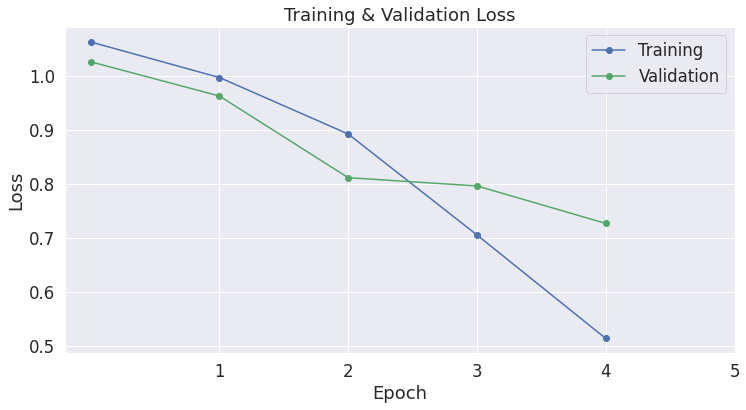

In [ ]:
import matplotlib.pyplot as plt

df_train=[1.063600 , 0.997600 , 0.892800 , 0.7055 , 0.5135  ]
df_valid=[1.026851 , 0.963279 , 0.811796 ,0.796516  , 0.726956]
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_train, 'b-o', label="Training")
plt.plot(df_valid, 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4,5])

plt.show()

In [ ]:
base_arabic.predict(test_dataset)

***** Running Prediction *****
  Num examples = 165
  Batch size = 32


PredictionOutput(predictions=array([[-2.5357728 ,  0.02413819,  2.650244  ],
       [-1.9494609 ,  1.4754573 ,  1.047764  ],
       [ 0.02614333,  1.2525812 , -0.34477556],
       [ 0.2946195 ,  2.0513418 , -1.3509223 ],
       [-2.6394844 ,  0.1401795 ,  2.7473807 ],
       [-1.7186868 ,  1.5042111 ,  1.5614669 ],
       [ 0.1301518 ,  1.8582093 , -1.0858635 ],
       [-2.41295   ,  1.2630141 ,  1.2910781 ],
       [-0.6502208 ,  1.6686276 , -0.3089819 ],
       [-2.1313903 ,  0.91278934,  1.5643805 ],
       [-1.9664435 ,  1.4966675 ,  0.5006025 ],
       [-0.6474646 ,  1.3522745 , -0.14137614],
       [-2.555839  ,  0.01460128,  2.6547859 ],
       [-1.9791162 ,  0.34615612,  2.1211066 ],
       [-1.4038845 ,  0.94313586,  1.023373  ],
       [-2.2941537 ,  0.01128633,  2.3610156 ],
       [-0.4224864 ,  1.478099  , -0.5114491 ],
       [-2.2186852 , -0.44114274,  2.5867167 ],
       [ 0.70565045,  1.8573998 , -1.8688377 ],
       [ 0.41529956,  1.9887847 , -1.1845025 ],
       [-2.

# **Test avec dialecte tunisien **

In [ ]:
from google.colab import files 
import io 
uploaded =files.upload()

Saving dataset1and2.xlsx to dataset1and2.xlsx


In [ ]:
df_tunisien = pd.read_excel(io.BytesIO(uploaded['dataset1and2.xlsx']))
df_tunisien.head() 

,Unnamed: 0,commentaire,classe
0,0,اسغي ياشعب تونس تدعوا بالاسلام كفار الحمدلله ن...,hate
1,1,قطع يد السارق توفرت الشروط شرط الحد الأدنى قيم...,normal
2,2,تلوموش لطفي لعبدلي شرف,normal
3,3,مستغرب شعب يسمع تفاهة شانو لى الدرجة الشعب تاف...,normal
4,4,هههخ غزلتني مافهمتش شمدخلها الموضوع تتنطر وحده...,normal


In [ ]:
df_tunisien['classe'].value_counts()

normal     3857
hate       1399
abusive    1204
Name: classe, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df_tunisien['Label']=le.fit_transform(df_tunisien['classe'])
df_tunisien.head(6)

,Unnamed: 0,commentaire,classe,Label
0,0,اسغي ياشعب تونس تدعوا بالاسلام كفار الحمدلله ن...,hate,1
1,1,قطع يد السارق توفرت الشروط شرط الحد الأدنى قيم...,normal,2
2,2,تلوموش لطفي لعبدلي شرف,normal,2
3,3,مستغرب شعب يسمع تفاهة شانو لى الدرجة الشعب تاف...,normal,2
4,4,هههخ غزلتني مافهمتش شمدخلها الموضوع تتنطر وحده...,normal,2
5,5,ترضى اليهود والنصارى تتبع ملتهم الحمد لله يوجد...,hate,1


In [ ]:
train_texts_tunisien, temp_texts_tunisien, train_labels_tunisien, temp_labels_tunisien = train_test_split(df_tunisien['commentaire'], df_tunisien['Label'], random_state=42, 
                                                                    test_size=0.3)

train_texts_tunisien=train_texts_tunisien.apply(preprocess)
temp_texts_tunisien=temp_texts_tunisien.apply(preprocess)

val_texts_tunisien, test_texts_tunisien, val_labels_tunisien, test_labels_tunisien = train_test_split(temp_texts_tunisien, temp_labels_tunisien, random_state=42, 
                                                                test_size=0.5)

len(train_texts_tunisien), len(val_texts_tunisien), len(test_texts_tunisien)

(4522, 969, 969)

In [ ]:
max_len = 0

# For every sentence...
for sent in test_texts_tunisien:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer_base_arabic.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  229


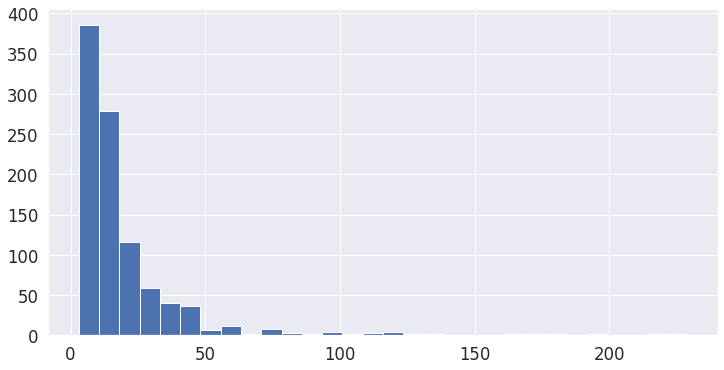

In [ ]:
seq_len = [len(tokenizer_base_arabic.encode(i)) for i in test_texts_tunisien]
#max_seq_len=max(seq_len)
pd.Series(seq_len).hist(bins = 30)

In [ ]:
test_encodings = tokenizer_base_arabic(test_texts_tunisien.to_list(), truncation=True, padding=True, max_length=max_len)
test_dataset_tunisien = preparerDataset(test_encodings, test_labels_tunisien)

In [ ]:
base_arabic.predict(test_dataset_tunisien)

***** Running Prediction *****
  Num examples = 969
  Batch size = 32


PredictionOutput(predictions=array([[-2.1854897 , -0.66616726,  2.8009892 ],
       [ 1.9940529 ,  1.1713294 , -2.3314338 ],
       [-1.2619617 ,  1.2474511 ,  0.512464  ],
       ...,
       [-0.13304064,  1.3859938 , -0.66909707],
       [-0.9808743 ,  0.8963785 ,  0.4383366 ],
       [-1.9352416 , -0.30728856,  2.43057   ]], dtype=float32), label_ids=array([2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 0, 0, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1,
       2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 1, 1, 1, 2, 2, 2, 0, 0, 1,
       2, 0, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 0, 1, 2, 2, 0, 0, 1, 1,
       0, 1, 0, 1, 2, 0, 2, 2, 2, 1, 2, 2, 0, 2, 2, 1, 2, 2, 0, 2, 2, 1,
       1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 1, 1, 0,
       2, 1, 2, 2, 1, 2, 2, 1, 0, 0, 1, 1, 2, 1, 0, 0, 2, 2, 2, 1, 2, 1,
       1, 2, 1, 0, 0, 0, 2, 0, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2,
       0, 2, 2, 2, 1, 1, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2,

# **Test avec multidialecte**

In [ ]:
from google.colab import files 
import io 
uploaded =files.upload()

Saving tunel_dataset_balanced.xlsx to tunel_dataset_balanced.xlsx


In [ ]:
df_tunel = pd.read_excel(io.BytesIO(uploaded['tunel_dataset_balanced.xlsx'])) #dataset obtenue apres augmentation du data 
df_tunel.head() 

,Unnamed: 0,Unnamed: 0.1,commentaire,classe,Label
0,11972,1936.0,يكفي انك جبان تسولف بالدايركت مثل الحريم تدور ...,hate,1
1,4647,1934.0,عشان انت بس مش وسخ زيها ولا وسح زيهم فده حصل ب...,normal,2
2,19141,698.0,لاغازيتا يا ربي لا عزاء لا ما عندكش نتفارضو ...,hate,1
3,8798,9683.0,قداه متخلق شمس ورجلة ياربك وقداه لطفي قليل ربا...,normal,2
4,5367,11101.0,هو فقط قال الحقيقة ما قدمت قطر للبنان ليس منحة...,normal,2


In [ ]:
df_tunel['Label'].value_counts()

2    9822
1    6063
0    5906
Name: Label, dtype: int64

In [ ]:
train_texts_tunel, temp_texts_tunel, train_labels_tunel, temp_labels_tunel = train_test_split(df_tunel['commentaire'], df_tunel['Label'], random_state=42, 
                                                                    test_size=0.3)

train_texts_tunel=train_texts_tunel.apply(preprocess)
temp_texts_tunel=temp_texts_tunel.apply(preprocess)
val_texts_tunel, test_texts_tunel, val_labels_tunel, test_labels_tunel = train_test_split(temp_texts_tunel, temp_labels_tunel, random_state=42, 
                                                                test_size=0.5)

len(train_texts_tunel), len(val_texts_tunel), len(test_texts_tunel)

(15253, 3269, 3269)

In [ ]:
max_len = 0

# For every sentence...
for sent in test_texts_tunel:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer_base_arabic.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  1094


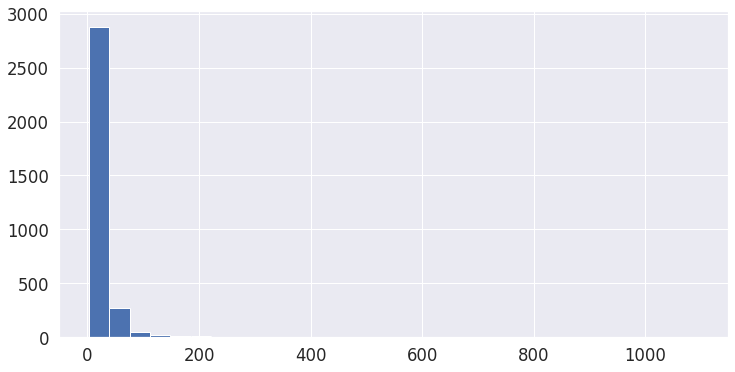

In [ ]:
seq_len = [len(tokenizer_base_arabic.encode(i)) for i in test_texts_tunel]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
test_encodings = tokenizer_base_arabic(test_texts_tunel.to_list(), truncation=True, padding=True, max_length=40)
test_dataset_tunel = preparerDataset(test_encodings, test_labels_tunel)

In [ ]:
base_arabic.predict(test_dataset_tunel)

***** Running Prediction *****
  Num examples = 3269
  Batch size = 32


PredictionOutput(predictions=array([[-0.20009488,  1.2839496 , -0.16241337],
       [ 1.483401  ,  1.3937869 , -1.8815186 ],
       [ 2.1887085 ,  0.5272586 , -1.9045564 ],
       ...,
       [-2.3942187 , -0.38773778,  2.8619728 ],
       [ 1.4068437 ,  1.6152055 , -2.1025038 ],
       [-1.6386682 ,  0.75824213,  0.9672445 ]], dtype=float32), label_ids=array([1, 1, 0, ..., 2, 2, 2]), metrics={'test_loss': 1.1556612253189087, 'test_accuracy': 0.5396145610278372, 'test_f1': 0.5095008653848312, 'test_precision': 0.5441114350206376, 'test_recall': 0.5095538451679982, 'test_runtime': 8.5042, 'test_samples_per_second': 384.397, 'test_steps_per_second': 12.112})

# test avec dialecte marocain 

In [ ]:
from google.colab import files 
import io 
uploaded =files.upload()

Saving dataset_marocain_balanced.xlsx to dataset_marocain_balanced.xlsx


In [ ]:
df_marocain = pd.read_excel(io.BytesIO(uploaded['dataset_marocain_balanced.xlsx'])) 
df_marocain.head() 

,Commentaire,Classe,Label
0,['ا ماتحشي iran يديك و في س غيران و مايعضوك ل ...,NaN,0
1,و زبي مكايدير تا لعبة الجوع كافر رئيس اتحاد مص...,hate,1
2,['انا · هنا بين اخواني و نجلس على [UNK] القضيب...,NaN,0
3,['اهداءاتالعصفورة هههه اه وي صبح لخير اجريت من...,NaN,0
4,['العزوبية حرية رخيصة moroccan وفراغ قاتل الرج...,NaN,1


In [ ]:
df_marocain['Label'].value_counts()

1    1365
2    1299
0    1222
Name: Label, dtype: int64

In [ ]:
train_texts_marocain, temp_texts_marocain, train_labels_marocain, temp_labels_marocain = train_test_split(df_marocain['Commentaire'], df_marocain['Label'], random_state=42, 
                                                                    test_size=0.3)

train_texts_marocain=train_texts_marocain.apply(preprocess)
temp_texts_marocain=temp_texts_marocain.apply(preprocess)
val_texts_marocain, test_texts_marocain, val_labels_marocain, test_labels_marocain = train_test_split(temp_texts_marocain, temp_labels_marocain, random_state=42, 
                                                                test_size=0.5)

len(train_texts_marocain), len(val_texts_marocain), len(test_texts_marocain)

(2720, 583, 583)

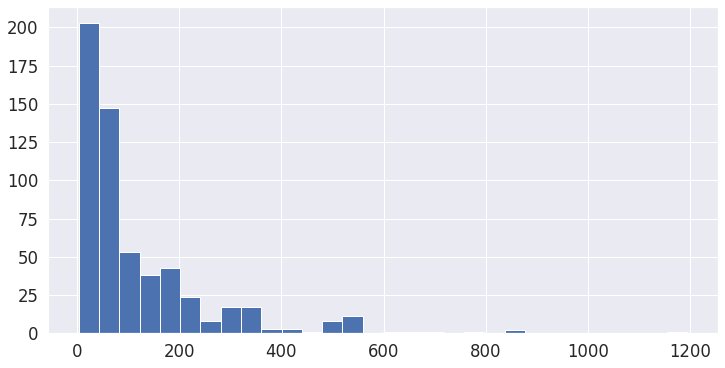

In [ ]:
seq_len = [len(tokenizer_base_arabic.encode(i)) for i in test_texts_marocain]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
test_encodings = tokenizer_base_arabic(test_texts_marocain.to_list(), truncation=True, padding=True, max_length=max_seq_len)
test_dataset_marocain = preparerDataset(test_encodings, test_labels_marocain)

In [ ]:
base_arabic.predict(test_dataset_marocain)

***** Running Prediction *****
  Num examples = 583
  Batch size = 32


PredictionOutput(predictions=array([[-1.083168  ,  1.1096156 ,  0.58711135],
       [ 0.7010178 ,  1.1600007 , -1.0251713 ],
       [-0.6447065 ,  1.0501202 ,  0.1038191 ],
       ...,
       [-2.0734124 ,  0.72214836,  1.688222  ],
       [-2.0348625 ,  0.7817773 ,  1.6235245 ],
       [-0.5084339 ,  1.5948119 , -0.08509258]], dtype=float32), label_ids=array([0, 2, 0, 2, 2, 1, 1, 1, 2, 0, 0, 1, 0, 1, 0, 1, 0, 2, 1, 2, 1, 2,
       2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 1, 2, 2, 1, 1, 0, 0, 2, 1, 1, 0, 0,
       0, 0, 1, 1, 2, 0, 2, 1, 0, 0, 2, 2, 1, 2, 1, 2, 1, 0, 2, 0, 1, 0,
       1, 1, 1, 1, 0, 2, 0, 1, 0, 2, 0, 2, 0, 1, 2, 0, 1, 0, 2, 0, 0, 2,
       1, 0, 1, 0, 2, 0, 2, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 2, 1, 2, 1, 1,
       0, 2, 1, 1, 1, 2, 0, 1, 1, 1, 1, 2, 0, 0, 2, 2, 2, 1, 0, 2, 2, 2,
       1, 2, 1, 0, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 2, 2, 0, 0, 1, 2, 0, 0,
       0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 1, 2, 1, 1, 0, 1, 2, 2, 2, 1, 0, 2,
       2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 1, 0, 1, 1,

# **test avec dialecte libanaise**


In [ ]:
from google.colab import files 
import io 
uploaded =files.upload()

Saving dataset3and4.xlsx to dataset3and4.xlsx


In [ ]:
df_egyptien = pd.read_excel(io.BytesIO(uploaded['dataset3and4.xlsx'])) 
df_egyptien.head() 

,Unnamed: 0,commentaire,classe
0,0.0,الوزير جبران باسيل تاج راسك يا جربان ممنوع بعد...,abusive
1,1.0,صديقي انت ابن جامعه اللعبه اكبر من داعش اللعبه...,normal
2,2.0,و مصلحة لبنان تبدأ باستخراج النفط و الغاز لوقف...,normal
3,3.0,وليد جنبلاط كاتب الحكمة يا قذر,abusive
4,4.0,شو بتلبقلك كلمة خنزير بتجي مفصله على قياسك وشك...,abusive


In [ ]:
df_egyptien['classe'].value_counts()

normal     4565
hate       2885
abusive    1746
Name: classe, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df_egyptien['Label']=le.fit_transform(df_egyptien['classe'])
df_egyptien.head(6)

,Unnamed: 0,commentaire,classe,Label
0,0.0,الوزير جبران باسيل تاج راسك يا جربان ممنوع بعد...,abusive,0
1,1.0,صديقي انت ابن جامعه اللعبه اكبر من داعش اللعبه...,normal,2
2,2.0,و مصلحة لبنان تبدأ باستخراج النفط و الغاز لوقف...,normal,2
3,3.0,وليد جنبلاط كاتب الحكمة يا قذر,abusive,0
4,4.0,شو بتلبقلك كلمة خنزير بتجي مفصله على قياسك وشك...,abusive,0
5,5.0,يا جبران باسيل يا معلم يا ريس يا استاذ بدك حضن...,normal,2


In [ ]:
train_texts_egyptien, temp_texts_egyptien, train_labels_egyptien, temp_labels_egyptien = train_test_split(df_egyptien['commentaire'], df_egyptien['Label'], random_state=42, 
                                                                    test_size=0.3)

train_texts_egyptien=train_texts_egyptien.apply(preprocess)
temp_texts_egyptien=temp_texts_egyptien.apply(preprocess)

val_texts_egyptien, test_texts_egyptien, val_labels_egyptien, test_labels_egyptien = train_test_split(temp_texts_egyptien, temp_labels_egyptien, random_state=42, 
                                                                test_size=0.5)

len(train_texts_egyptien), len(val_texts_egyptien), len(test_texts_egyptien)

(6437, 1379, 1380)

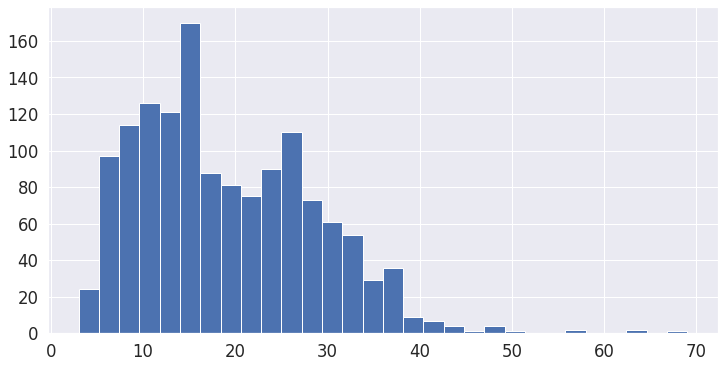

In [ ]:
seq_len = [len(tokenizer_base_arabic.encode(i)) for i in test_texts_egyptien]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
test_encodings = tokenizer_base_arabic(test_texts_egyptien.to_list(), truncation=True, padding=True, max_length=40)
test_dataset_egyptien = preparerDataset(test_encodings, test_labels_egyptien)

In [ ]:
base_arabic.predict(test_dataset_egyptien)

***** Running Prediction *****
  Num examples = 1380
  Batch size = 32


PredictionOutput(predictions=array([[-1.8066152 ,  1.0882653 ,  0.82243073],
       [-1.3635712 ,  0.29996097,  0.85771096],
       [-2.4769278 ,  0.07703752,  2.512195  ],
       ...,
       [ 0.012545  ,  1.3553177 , -0.24494898],
       [-1.2180073 ,  0.7046262 ,  0.28655633],
       [-1.904658  , -0.09305899,  1.8310416 ]], dtype=float32), label_ids=array([1, 1, 1, ..., 1, 0, 0]), metrics={'test_loss': 1.1077220439910889, 'test_accuracy': 0.5442028985507247, 'test_f1': 0.45265292950597913, 'test_precision': 0.4597928277297026, 'test_recall': 0.45568380572014516, 'test_runtime': 3.3709, 'test_samples_per_second': 409.384, 'test_steps_per_second': 13.053})

# **augmenter data **

In [ ]:
import nlpaug.augmenter.word.context_word_embs as aug

In [ ]:
augmenter = aug.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")


https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpwac39je4


storing https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
creating metadata file for /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
https://huggingface.co/bert-base-uncased/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp9n5nfaxr


storing https://huggingface.co/bert-base-uncased/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
creating metadata file for /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "h

storing https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
creating metadata file for /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
https://huggingface.co/bert-base-uncased/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpgiikf6cz


storing https://huggingface.co/bert-base-uncased/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
creating metadata file for /root/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://hugg

storing https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
creating metadata file for /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f


In [ ]:
from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB
import numpy as np
from tqdm.auto import tqdm

In [ ]:
from IPython.core.display import Javascript
def augmentMyData(df, augmenter, repetitions=1, sample0=200,sample1=200):
    for j in [0,1] :
      if j==0 :
        samples=sample0
      else :
        samples=sample1
      augmented_texts = []
      # select only the minority class samples
      spam_df = df[df['Label'] == j].reset_index(drop=True) # removes unecessary index column
      for i in tqdm(np.random.randint(0, len(spam_df), samples)):
          # generating 'n_samples' augmented texts
          for _ in range(repetitions):
              augmented_text = augmenter.augment(spam_df['commentaire'].iloc[i])
              augmented_texts.append(augmented_text)
      
      data = {
          'Label': j,
          'commentaire': augmented_texts
      }
      aug_df = pd.DataFrame(data)
      df = shuffle(df.append(aug_df).reset_index(drop=True))
    return df

In [ ]:
new_df = augmentMyData(df, augmenter,sample0=100,sample1=10)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
new_df.to_excel('D5_balanced_dataset.xlsx')

In [ ]:
df2 = pd.read_excel('D5_balanced_dataset.xlsx')
df2.head() 

,Unnamed: 0,commentaire,classe,Label
0,394,['arabic العجلة 1 دي morocco تبقي ل امك'],NaN,0
1,1019,طلعت بتدور علي فرصه تبيع نفسك فيها لحد ما وصلت...,hate,1
2,1159,قشطه عليك يابو سلمي..بس ايه رأيك في سيدك السيس...,abusive,0
3,742,كس امك,abusive,0
4,222,سيبك انت .كنت مسخرة يا ريس الله ينور وبرضو كال...,hate,1


In [ ]:
df2['Label'].value_counts()

1    454
2    453
0    303
Name: Label, dtype: int64

In [ ]:
df['Label'].value_counts()

2    453
1    444
0    203
Name: Label, dtype: int64

In [ ]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df2['commentaire'], df2['Label'], random_state=42, 
                                                                    test_size=0.3)

train_texts=train_texts.apply(preprocess)
temp_texts=temp_texts.apply(preprocess)

val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, random_state=42, 
                                                                test_size=0.5)

len(train_texts), len(val_texts), len(test_texts)

(847, 181, 182)

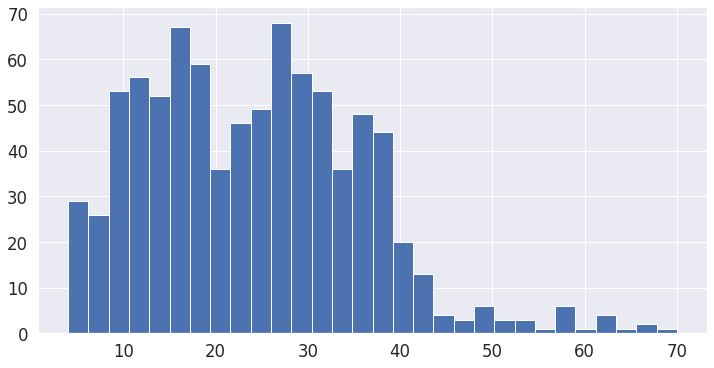

In [ ]:
seq_len = [len(tokenizer_base_arabic.encode(i)) for i in train_texts]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
train_encodings = tokenizer_base_arabic(train_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)
val_encodings = tokenizer_base_arabic(val_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)
test_encodings = tokenizer_base_arabic(test_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)

In [ ]:
train_dataset = preparerDataset(train_encodings, train_labels)
val_dataset = preparerDataset(val_encodings, val_labels)
test_dataset = preparerDataset(test_encodings, test_labels)

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_strategy='epoch',
    evaluation_strategy='epoch'
    )

base_arabic_apres_augmentation = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    compute_metrics=compute_metrics
)

base_arabic_apres_augmentation.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 847
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 265


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.459900,0.320251,0.906077,0.904726,0.907195,0.904700
2,0.343000,0.299905,0.900552,0.897586,0.892873,0.907480
3,0.221000,0.379101,0.856354,0.855741,0.867911,0.847282
4,0.105600,0.359504,0.867403,0.864332,0.872897,0.859625
5,0.095900,0.547950,0.872928,0.870488,0.890380,0.870543


***** Running Evaluation *****
  Num examples = 181
  Batch size = 32
***** Running Evaluation *****
  Num examples = 181
  Batch size = 32
***** Running Evaluation *****
  Num examples = 181
  Batch size = 32
***** Running Evaluation *****
  Num examples = 181
  Batch size = 32
***** Running Evaluation *****
  Num examples = 181
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=265, training_loss=0.24506480738801775, metrics={'train_runtime': 66.5353, 'train_samples_per_second': 63.65, 'train_steps_per_second': 3.983, 'total_flos': 152343696651300.0, 'train_loss': 0.24506480738801775, 'epoch': 5.0})

In [ ]:
base_arabic_apres_augmentation.predict(test_dataset)

***** Running Prediction *****
  Num examples = 182
  Batch size = 32


PredictionOutput(predictions=array([[-1.4640520e+00,  4.8097200e+00, -3.5168810e+00],
       [ 3.6668267e+00,  9.4411069e-01, -4.6039772e+00],
       [-3.5907874e+00, -9.7890121e-01,  4.5303650e+00],
       [ 5.2011080e+00, -1.6653322e+00, -3.1933055e+00],
       [-2.5567749e+00,  5.1424484e+00, -2.8610101e+00],
       [-2.8581772e+00,  4.9036980e+00, -2.4095657e+00],
       [-3.6510630e+00,  3.9802608e+00, -3.8434944e-01],
       [-2.6372910e+00,  5.3985863e+00, -2.5161817e+00],
       [-2.2336266e+00, -2.6723590e+00,  4.7779675e+00],
       [-2.6757658e+00, -2.3658412e+00,  4.9938402e+00],
       [ 5.2588019e+00, -2.3780060e+00, -2.5969865e+00],
       [-2.9485955e+00,  5.2082405e+00, -2.3321240e+00],
       [ 1.5781007e+00,  2.6956077e+00, -4.3052430e+00],
       [-3.4705811e+00,  5.0249281e+00, -1.4823952e+00],
       [-3.9158747e+00,  1.0795021e+00,  2.8684289e+00],
       [-3.5491490e+00,  4.1507716e+00, -4.9550831e-01],
       [-2.2936502e+00, -2.7280006e+00,  4.8812261e+00],
  

In [ ]:
base_arabic_apres_augmentation.predict(test_dataset_tunisien)

***** Running Prediction *****
  Num examples = 969
  Batch size = 32


PredictionOutput(predictions=array([[-2.206935  , -2.3336375 ,  4.6578035 ],
       [ 4.6589084 , -0.28111592, -4.2605724 ],
       [-2.5843806 ,  5.08325   , -2.5471098 ],
       ...,
       [-3.2064495 ,  4.4517817 , -1.5749447 ],
       [-3.8981874 ,  3.4576874 ,  0.19797686],
       [-2.6339848 , -1.5338401 ,  4.012995  ]], dtype=float32), label_ids=array([2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 0, 0, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1,
       2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 1, 1, 1, 2, 2, 2, 0, 0, 1,
       2, 0, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 0, 1, 2, 2, 0, 0, 1, 1,
       0, 1, 0, 1, 2, 0, 2, 2, 2, 1, 2, 2, 0, 2, 2, 1, 2, 2, 0, 2, 2, 1,
       1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 1, 1, 0,
       2, 1, 2, 2, 1, 2, 2, 1, 0, 0, 1, 1, 2, 1, 0, 0, 2, 2, 2, 1, 2, 1,
       1, 2, 1, 0, 0, 0, 2, 0, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2,
       0, 2, 2, 2, 1, 1, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2,

In [ ]:
base_arabic_apres_augmentation.predict(test_dataset_egyptien)

***** Running Prediction *****
  Num examples = 1380
  Batch size = 32


PredictionOutput(predictions=array([[-1.4529351 ,  4.4165688 , -3.5678616 ],
       [-2.7925763 ,  1.5388342 ,  0.8849907 ],
       [-3.9581738 ,  3.1355755 ,  0.98438835],
       ...,
       [-2.588008  ,  4.863987  , -1.9778829 ],
       [-2.7888613 ,  4.6786594 , -2.1619473 ],
       [-3.3427846 ,  0.606381  ,  2.6340685 ]], dtype=float32), label_ids=array([1, 1, 1, ..., 1, 0, 0]), metrics={'test_loss': 2.9073216915130615, 'test_accuracy': 0.49782608695652175, 'test_f1': 0.4197653982145757, 'test_precision': 0.4776833519741213, 'test_recall': 0.4397553603529525, 'test_runtime': 3.5125, 'test_samples_per_second': 392.881, 'test_steps_per_second': 12.527})

In [ ]:
base_arabic_apres_augmentation.predict(test_dataset_tunel)

***** Running Prediction *****
  Num examples = 3269
  Batch size = 32


PredictionOutput(predictions=array([[-1.5476367 ,  4.7426186 , -3.3404841 ],
       [ 4.2484584 ,  0.17005952, -4.276016  ],
       [ 5.1212907 , -2.4122567 , -2.243571  ],
       ...,
       [-3.904801  ,  0.07366028,  4.0289555 ],
       [ 0.5458209 ,  3.6642687 , -4.5192037 ],
       [-3.3197396 ,  1.0128322 ,  2.216513  ]], dtype=float32), label_ids=array([1, 1, 0, ..., 2, 2, 2]), metrics={'test_loss': 2.6563122272491455, 'test_accuracy': 0.5200367084735393, 'test_f1': 0.529777270599837, 'test_precision': 0.634378088379339, 'test_recall': 0.5435800838693093, 'test_runtime': 8.5057, 'test_samples_per_second': 384.33, 'test_steps_per_second': 12.11})

In [ ]:
base_arabic_apres_augmentation.predict(test_dataset_marocain)

***** Running Prediction *****
  Num examples = 583
  Batch size = 32


PredictionOutput(predictions=array([[-0.6446825,  4.1692247, -4.1573524],
       [-1.4332515,  4.666894 , -3.6821811],
       [ 5.025329 , -1.3943577, -3.565038 ],
       ...,
       [-1.4054543,  2.6424074, -0.910697 ],
       [-2.306572 ,  4.485659 , -2.1808271],
       [-1.4209166,  4.725898 , -3.6464858]], dtype=float32), label_ids=array([0, 2, 0, 2, 2, 1, 1, 1, 2, 0, 0, 1, 0, 1, 0, 1, 0, 2, 1, 2, 1, 2,
       2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 1, 2, 2, 1, 1, 0, 0, 2, 1, 1, 0, 0,
       0, 0, 1, 1, 2, 0, 2, 1, 0, 0, 2, 2, 1, 2, 1, 2, 1, 0, 2, 0, 1, 0,
       1, 1, 1, 1, 0, 2, 0, 1, 0, 2, 0, 2, 0, 1, 2, 0, 1, 0, 2, 0, 0, 2,
       1, 0, 1, 0, 2, 0, 2, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 2, 1, 2, 1, 1,
       0, 2, 1, 1, 1, 2, 0, 1, 1, 1, 1, 2, 0, 0, 2, 2, 2, 1, 0, 2, 2, 2,
       1, 2, 1, 0, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 2, 2, 0, 0, 1, 2, 0, 0,
       0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 1, 2, 1, 1, 0, 1, 2, 2, 2, 1, 0, 2,
       2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 1, 0, 1, 1, 1, 2, 1, 0,
     

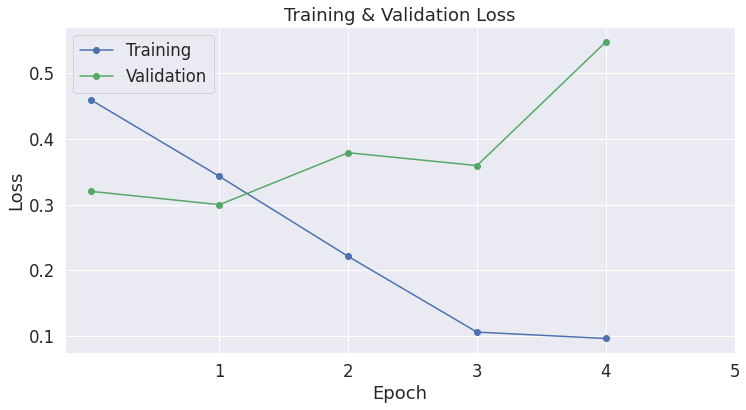

In [ ]:
import matplotlib.pyplot as plt

df_train=[0.4599 , 0.343 , 0.221 , 0.1056 , 0.095900]
df_valid=[0.320251 , 0.299905 , 0.379101 ,0.359504  , 0.547950]
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_train, 'b-o', label="Training")
plt.plot(df_valid, 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4,5])

plt.show()